# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation.

This notebook and train.py script in source folder were derived from [spleen_segmentation_3d notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

### install and import monai libraries 

In [406]:
!pip install  "monai[all]==0.8.0"

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [407]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [408]:
import numpy as np
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import math
from pathlib import Path
import sagemaker 
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch


role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose from MONAI
+ Visualize the image 

In [409]:
# Download the images
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"
data_dir = "Spleen3D" 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir+'/datasets', md5)

In [410]:
## transform the images through Compose
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


In [455]:
## divide the images into training and testing dataset
train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, test_demo_files = data_dicts[:-1], data_dicts[-1:]

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


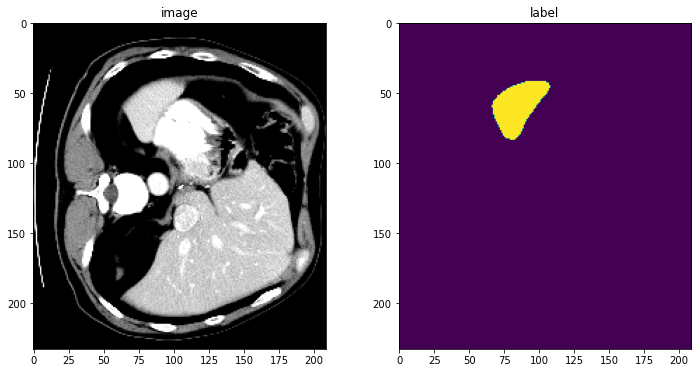

In [651]:
# Visualization
check_ds = Dataset(data=test_demo_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot only the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Divide the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [457]:
prefix="MONAI_Segmentation"

processed_train_path = os.path.join(data_dir,"processed","train")
processed_test_path = os.path.join(data_dir,"processed","test")

processed_train_images_path = os.path.join(processed_train_path, "imagesTr")
processed_train_labels_path = os.path.join(processed_train_path, "labelsTr")

processed_test_images_path = os.path.join(processed_test_path, "imagesTr")
processed_test_labels_path = os.path.join(processed_test_path, "labelsTr")

Path(processed_train_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_train_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_train_path)

Path(processed_test_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_test_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_test_path)

Directory 'Spleen3D/processed/train' created
Directory 'Spleen3D/processed/test' created


In [458]:
## copy dataset for training 
for file in train_files:
    images = file['image']
    images_dest = processed_train_images_path
    label = file['label']
    label_dest = processed_train_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

In [459]:
## copy dataset for testing  
for file in test_demo_files:
    images = file['image']
    images_dest = processed_test_images_path
    label = file['label']
    label_dest = processed_test_labels_path
    shutil.copy(images,images_dest)
    shutil.copy(label,label_dest)

In [460]:
## upload training dataset to S3
S3_inputs = sess.upload_data(
    path=processed_train_path,
    key_prefix=prefix+"/train",
    bucket=bucket 
)

## upload testing dataset to S3
S3_demo_test = sess.upload_data(
    path=processed_test_images_path,
    key_prefix=prefix+"/demo_test",
    bucket=bucket 
)

In [719]:
## upload testing dataset
img_test_path = os.path.join(data_dir, "datasets/Task09_Spleen/imagesTs")

S3_img_test = sess.upload_data(
    path=img_test_path,
    key_prefix=prefix+"/img_test",
    bucket=bucket 
)

### SageMaker training job

In [417]:
%time

metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]

estimator = PyTorch(source_dir='code',
                    entry_point='train.py',
                    role=role,
                    framework_version='1.6.0',
                    py_version='py3',
                    instance_count=1,
#                     instance_type='ml.p2.xlarge',
                    instance_type='ml.p3.2xlarge',
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 200
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
2022-04-24 20:52:54 Starting - Starting the training job...
2022-04-24 20:53:19 Starting - Preparing the instances for trainingProfilerReport-1650833573: InProgress
.........
2022-04-24 20:54:37 Downloading - Downloading input data...
2022-04-24 20:55:17 Training - Downloading the training image............
2022-04-24 20:57:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-24 20:57:17,124 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-24 20:57:17,150 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-24 20:57:17,159 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-24 20:57:17,616 sagemaker-training-toolkit INFO     Installing dependencies from requir

In [418]:
model_data=estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]

## Inference 

+ deploy the model with customized inference script
+ inference with testing image in S3
+ visualization the results

In [734]:
%timeit

from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    entry_point="inference.py", ## inference code with customization
    source_dir="code",        ## folder with the inference code
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)

predictor = model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m5.2xlarge',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

--------!

In [912]:
prefix_key = prefix+"/demo_test"
file = test_demo_files[0]["image"].split("/")[-1]
print(file)
totalslice = np.array(image).shape[-1]
print(totalslice)

spleen_9.nii.gz
101


In [913]:
%timeit
test_demo_preds=[]
# totalslice = 30 #comment out if using the entire scan
for counter in range(totalslice):
    payload={
        "bucket": bucket,
        "key": prefix_key,
        "file": file,
        "nslice": counter
            }
    response_pred=predictor.predict(payload)
    print("inference for slice",counter)
    test_demo_preds.append(response_pred)

inference for slice 0
inference for slice 1
inference for slice 2
inference for slice 3
inference for slice 4
inference for slice 5
inference for slice 6
inference for slice 7
inference for slice 8
inference for slice 9
inference for slice 10
inference for slice 11
inference for slice 12
inference for slice 13
inference for slice 14
inference for slice 15
inference for slice 16
inference for slice 17
inference for slice 18
inference for slice 19
inference for slice 20
inference for slice 21
inference for slice 22
inference for slice 23
inference for slice 24
inference for slice 25
inference for slice 26
inference for slice 27
inference for slice 28
inference for slice 29
inference for slice 30
inference for slice 31
inference for slice 32
inference for slice 33
inference for slice 34
inference for slice 35
inference for slice 36
inference for slice 37
inference for slice 38
inference for slice 39
inference for slice 40
inference for slice 41
inference for slice 42
inference for slice 4

In [917]:
nslice = 50 #must be 1 less than total slice

test_demo_ds = check_ds
test_demo_loader = check_loader
test_demo_data = check_data

In [918]:
torch.tensor(test_demo_preds[nslice]['pred'])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

## Visualize the result

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


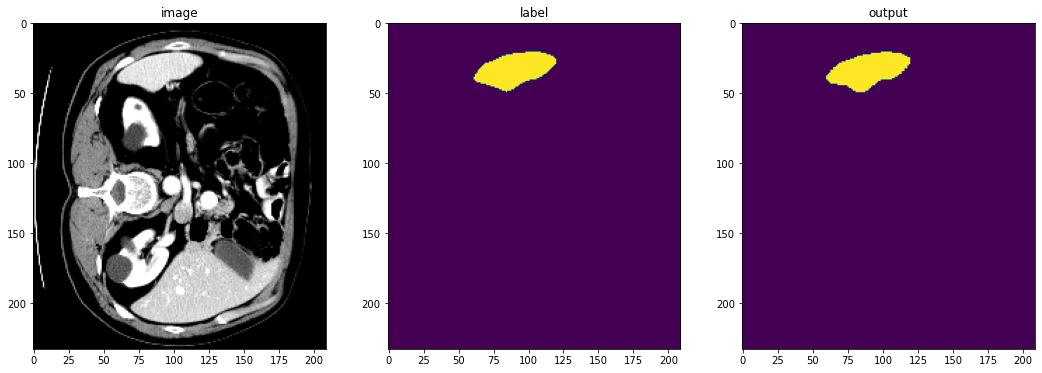

In [919]:
image, label = (test_demo_data["image"][0][0], test_demo_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Visualization
# plot the slice [:, :, nslice]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(test_demo_data["image"][0, 0, :, :, nslice], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(test_demo_data["label"][0, 0, :, :, nslice])
plt.subplot(1, 3, 3)
plt.title("output")
plt.imshow(test_demo_preds[nslice]['pred'])

plt.show()

## Test Data

In [740]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)

In [876]:
loader = LoadImage()

test_images = sorted(glob.glob(os.path.join(img_test_path, "*.nii.gz")))
test_dicts = [{"image": image_name} for image_name in test_images]

test_ds = Dataset(data=test_dicts, transform=test_org_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)

In [909]:
%timeit
# inference
infer_key = prefix+"/img_test"

# img_ls = range(len(test_dicts))
img_ls = range(3) #swap out if you want to use the full set of images

predictions = []
for item in img_ls:
    infer_file = test_dicts[item]["image"].split("/")[-1]
    print(f"Started prediction for image {infer_file}")
    img = test_data["image"][0][0][item]
    
#     slices = np.array(img).shape[-1]
    slices = 50 #swap out if you want to use the full scan
    
    print("slices:", slices)
    pred_img = []
    for count in range(slices):
        payload={
            "bucket": bucket,
            "key": infer_key,
            "file": infer_file,
            "nslice": count
                }
        response_test=predictor.predict(payload)
        print("slice", count)
        pred_img.append(response_test)
    predictions.append(pred_img)
    print(f"Completed prediction for image {infer_file}")

Started prediction for image spleen_1.nii.gz
slices: 50
slice 0
slice 1
slice 2
slice 3
slice 4
slice 5
slice 6
slice 7
slice 8
slice 9
slice 10
slice 11
slice 12
slice 13
slice 14
slice 15
slice 16
slice 17
slice 18
slice 19
slice 20
slice 21
slice 22
slice 23
slice 24
slice 25
slice 26
slice 27
slice 28
slice 29
slice 30
slice 31
slice 32
slice 33
slice 34
slice 35
slice 36
slice 37
slice 38
slice 39
slice 40
slice 41
slice 42
slice 43
slice 44
slice 45
slice 46
slice 47
slice 48
slice 49
Completed prediction for image spleen_1.nii.gz
Started prediction for image spleen_11.nii.gz
slices: 50
slice 0
slice 1
slice 2
slice 3
slice 4
slice 5
slice 6
slice 7
slice 8
slice 9
slice 10
slice 11
slice 12
slice 13
slice 14
slice 15
slice 16
slice 17
slice 18
slice 19
slice 20
slice 21
slice 22
slice 23
slice 24
slice 25
slice 26
slice 27
slice 28
slice 29
slice 30
slice 31
slice 32
slice 33
slice 34
slice 35
slice 36
slice 37
slice 38
slice 39
slice 40
slice 41
slice 42
slice 43
slice 44
slice

In [910]:
item = 0
sliceno = 45
slices = test_dicts[item]["image"].split("/")[-1]
print(slices)
torch.tensor(predictions[item][sliceno]["pred"]).size()

spleen_1.nii.gz


torch.Size([219, 173])

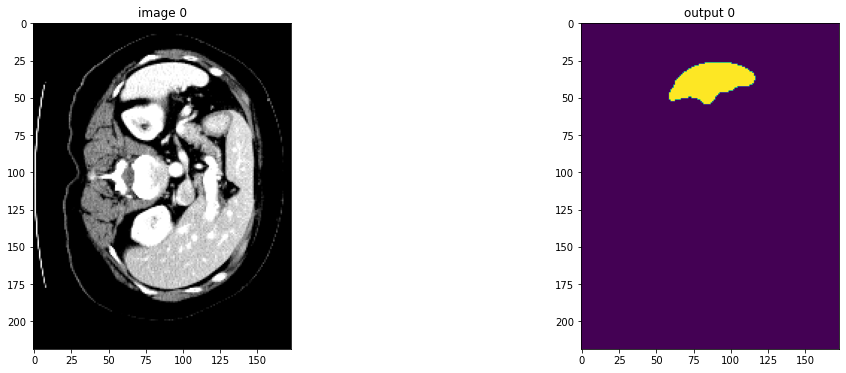

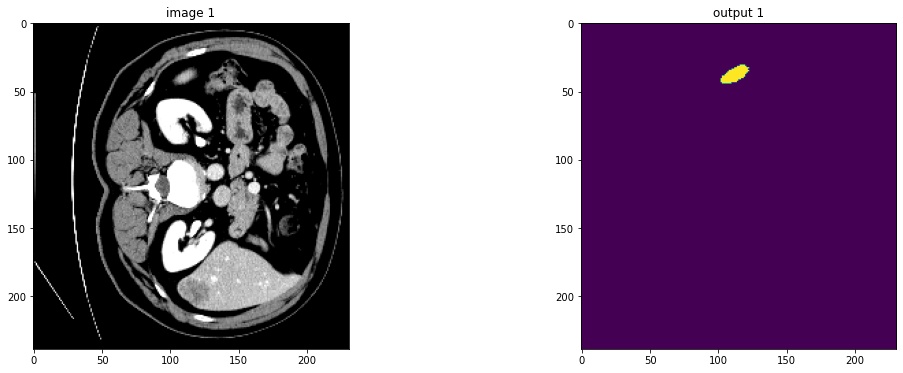

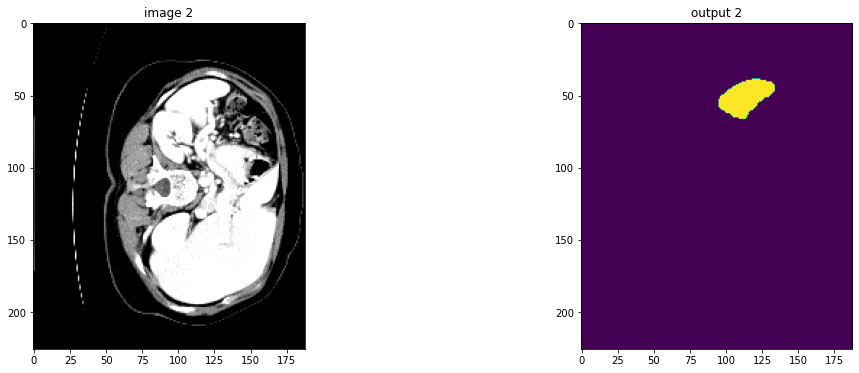

In [911]:
for i, test_data in enumerate(test_loader):
    # plot the slice [:, :, sliceno]
    plt.figure("check", (18, 6))
    plt.subplot(1, 2, 1)    
    plt.title(f"image {i}")
    plt.imshow(test_data["image"][0][0, :, :, sliceno], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"output {i}")
    plt.imshow(predictions[i][sliceno]["pred"])
    plt.show()    
    if i+1 == len(img_ls):
        break

## Clean up the resources

+ delete endpoints to save cost

In [ ]:
#delete current endpoint
predictor.delete_predictor(delete_endpoint_config=True)

In [ ]:
#delete all the endpoints to save cost
import boto3
client = boto3.client('sagemaker')
endpoints=client.list_endpoints()['Endpoints']
for endpoint in endpoints:
    response = client.delete_endpoint(
        EndpointName=endpoint['EndpointName']
    )